DEEP LEARNING PROJECT

PROBLEM STATEMENT: AI diagnostics in bone oncology for predicting bone metastasis in lung cancer patients

1. S SWARATHMICA - 125156119
2. PARITOSH SRIVASTAVA- 125156083
3. GOPIDI PRANAY - 125156086
4. KARTHIK NARAYAN MOHAN - 125156054 

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [15]:
# Load EfficientNetB0 with preprocessing
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Modify the final output layer to match the number of classes 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # Use 'softmax' for multi-class classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model for multi-class classification
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define your dataset directory and target directories for split
train_dir = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\train"
val_dir = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\val"
test_dir = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\test"


In [18]:
img_height, img_width = 224, 224
# Created ImageDataGenerators with data augmentation
# Use EfficientNet's built-in preprocessing in generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,  # Add this
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'  # or 'binary', depending on your case
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'  # or 'binary', depending on your case
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',  # or 'binary', depending on your case
    shuffle=False  # Important for evaluation
)

Found 767 images belonging to 3 classes.
Found 164 images belonging to 3 classes.
Found 166 images belonging to 3 classes.


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(
    train_generator,
    epochs=200,  # Adjust as needed
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
      # Add the callback here
)

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.6178 - loss: 1.3744 - val_accuracy: 0.8062 - val_loss: 0.6817
Epoch 2/200
 1/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7812 - loss: 1.2508

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.7812 - loss: 1.2508 - val_accuracy: 0.8062 - val_loss: 0.6368
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.7659 - loss: 1.2609 - val_accuracy: 0.8188 - val_loss: 0.5774
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.7188 - loss: 1.5194 - val_accuracy: 0.8250 - val_loss: 0.6166
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7831 - loss: 1.0701 - val_accuracy: 0.8375 - val_loss: 0.5658
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.7812 - loss: 0.9747 - val_accuracy: 0.8250 - val_loss: 0.5855
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7974 - loss: 0.9362 - val_accuracy: 0.7000 - val_loss: 0.8338
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.7188 - loss: 1.2864 - val_accuracy: 0.7250 - val_loss: 0.7366
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8214 - loss: 0.8729 - val_accuracy: 0.8313 - val_

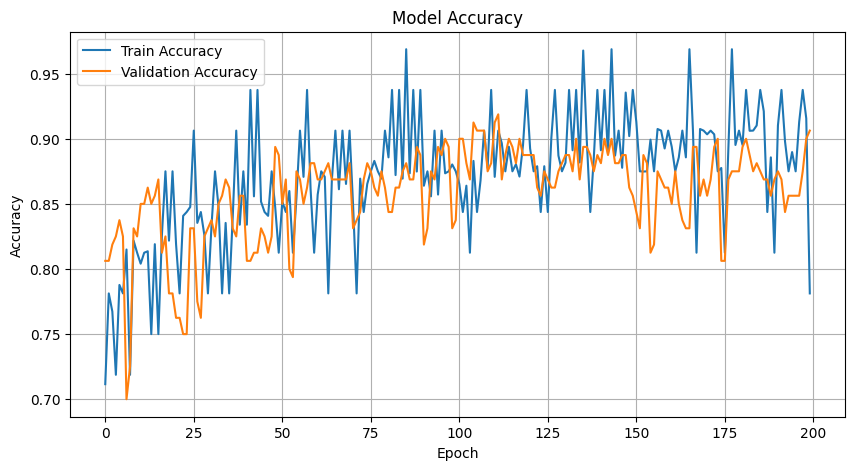

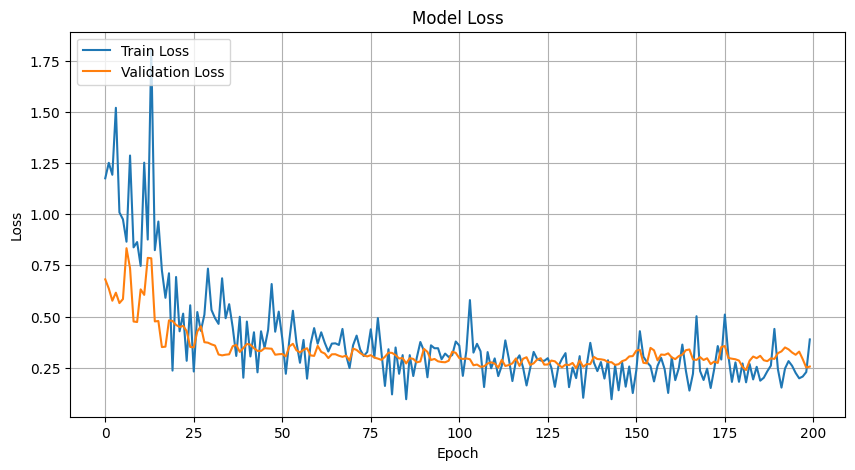

In [20]:
import matplotlib.pyplot as plt

# Plot the accuracy
def plot_accuracy(history):
    plt.figure(figsize=(10, 5))  # Optional: Set figure size for better visualization
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history: # Check if validation accuracy exists
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()  # Optional: Add grid for better readability
    plt.show()

# Plot the loss
def plot_loss(history):
    plt.figure(figsize=(10, 5))  # Optional: Set figure size for better visualization
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:  # Check if validation loss exists
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()  # Optional: Add grid for better readability
    plt.show()

# Call the plot functions
plot_accuracy(history)
plot_loss(history)


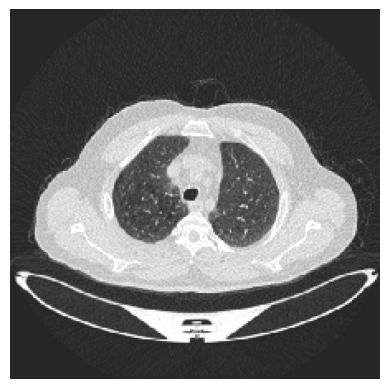

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: benign
Prediction confidence: 69.87%


In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt



# Path to the image you want to predict
image_path = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\test\Normal cases\Normal case (1).jpg"

# Step 1: Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input shape
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Step 2: Preprocess the image
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Step 3: Make a prediction
predictions = model.predict(img_array)

# Step 4: Interpret the prediction
class_indices = {0: 'normal', 1: 'malignant', 2: 'benign'}  # Update according to your dataset's class indices
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest score

# Display the result
print(f"Predicted class: {class_indices[predicted_class[0]]}")
print(f"Prediction confidence: {np.max(predictions) * 100:.2f}%")


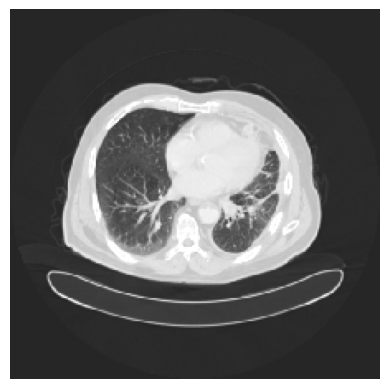

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted class: benign
Prediction confidence: 69.82%


In [22]:
image_path = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\test\Malignant cases\Malignant case (1).jpg"

# Step 1: Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input shape
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Step 2: Preprocess the image
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Step 3: Make a prediction
predictions = model.predict(img_array)

# Step 4: Interpret the prediction
class_indices = {0: 'normal', 1: 'malignant', 2: 'benign'}  # Update according to your dataset's class indices
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest score

# Display the result
print(f"Predicted class: {class_indices[predicted_class[0]]}")
print(f"Prediction confidence: {np.max(predictions) * 100:.2f}%")


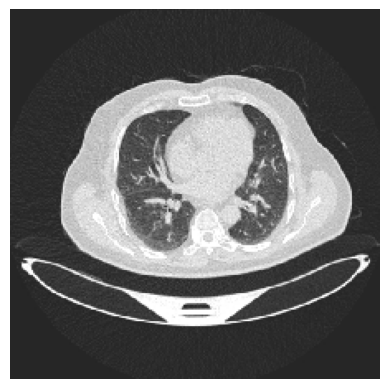

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted class: benign
Prediction confidence: 69.83%


In [23]:
image_path = r"C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\test\Bengin cases\Bengin case (1).jpg"
# Step 1: Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input shape
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Step 2: Preprocess the image
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Step 3: Make a prediction
predictions = model.predict(img_array)

# Step 4: Interpret the prediction
class_indices = {0: 'normal', 1: 'malignant', 2: 'benign'}  # Update according to your dataset's class indices
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest score

# Display the result
print(f"Predicted class: {class_indices[predicted_class[0]]}")
print(f"Prediction confidence: {np.max(predictions) * 100:.2f}%")


5/6 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020C285B3880> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
True labels: 166, Predictions: 166


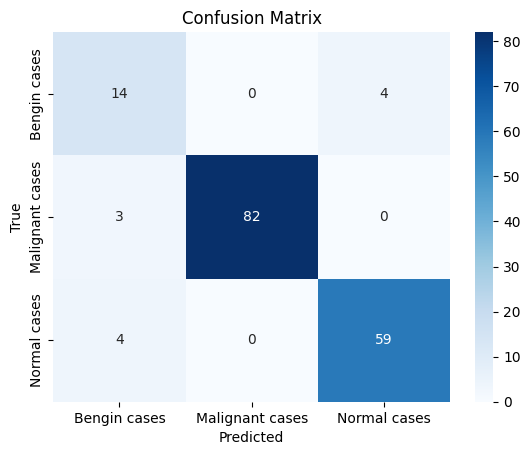

                 precision    recall  f1-score   support

   Bengin cases       0.67      0.78      0.72        18
Malignant cases       1.00      0.96      0.98        85
   Normal cases       0.94      0.94      0.94        63

       accuracy                           0.93       166
      macro avg       0.87      0.89      0.88       166
   weighted avg       0.94      0.93      0.94       166



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
test_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Get true labels
true_classes = test_generator.classes

# Ensure sizes match
print(f"True labels: {len(true_classes)}, Predictions: {len(test_pred_classes)}")

# Confusion Matrix
cm = confusion_matrix(true_classes, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_classes, test_pred_classes, target_names=list(test_generator.class_indices.keys())))

